Dataset Class Distribution:
pituitary: 1757 samples
healthy: 2000 samples
meningioma: 1645 samples
glioma: 1621 samples


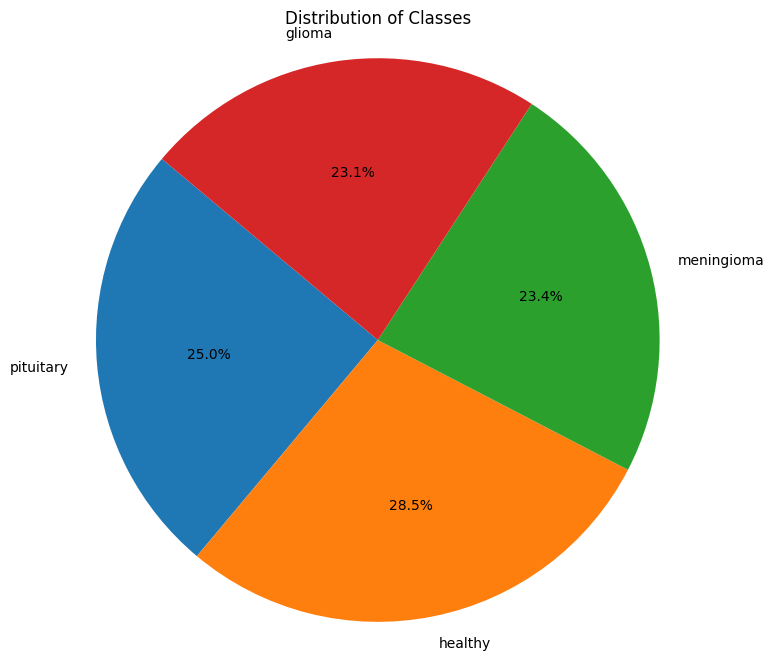

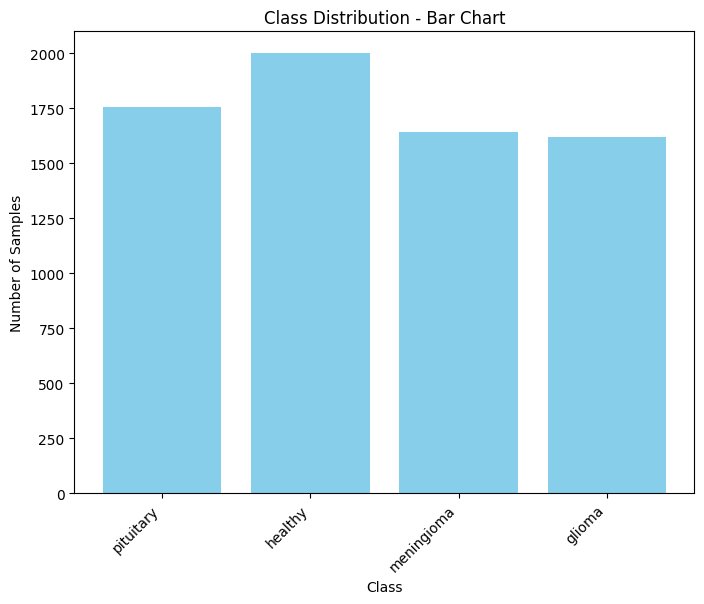

In [2]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

# Define dataset directory and image parameters
data_dir = '/kaggle/input/brain-tumor-mri-scans'  # Update this with your dataset path
img_height, img_width = 128, 128  # Resize all images to 128*128
batch_size = 32

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy arrays to PIL images
    transforms.Resize((img_height, img_width)),  # Resize images
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,)),  # Normalize to range [-1, 1]
    #transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 0.1)),
    # transforms.ColorJitter(brightness=(0.8, 1.2))
])

# Custom Dataset Class
class BrainTumorDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.label_map = {label: idx for idx, label in enumerate(os.listdir(data_dir))}

        for label in os.listdir(data_dir):
            class_dir = os.path.join(data_dir, label)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                try:
                    img = cv2.imread(img_path)
                    if img is not None:  # Skip invalid images
                        self.images.append(img)
                        self.labels.append(self.label_map[label])
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Load the dataset
dataset = BrainTumorDataset(data_dir, transform=transform)

# Extract the label map for converting numeric labels back to class names
label_map = {idx: label for label, idx in dataset.label_map.items()}  # Reverse mapping

# Count the number of samples in each class
class_counts = {}
for img, label in dataset:
    class_label = label_map[label]  # No need for .item() here
    class_counts[class_label] = class_counts.get(class_label, 0) + 1

# Extract class labels and counts
class_labels = list(class_counts.keys())
class_counts_values = list(class_counts.values())

# Print dataset statistics for each class
print("Dataset Class Distribution:")
for label, count in zip(class_labels, class_counts_values):
    print(f"{label}: {count} samples")

# Create a pie chart to visualize class distribution
plt.figure(figsize=(8, 8))
plt.pie(class_counts_values, labels=class_labels, autopct="%1.1f%%", startangle=140)
plt.title("Distribution of Classes")
plt.axis("equal")  # Equal aspect ratio ensures a circular pie chart
plt.show()

# Create a bar chart to visualize class distribution
plt.figure(figsize=(8, 6))
plt.bar(class_labels, class_counts_values, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution - Bar Chart')
plt.xticks(rotation=45, ha='right')
plt.show()






In [3]:
# Now split the dataset into training, validation, and testing
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



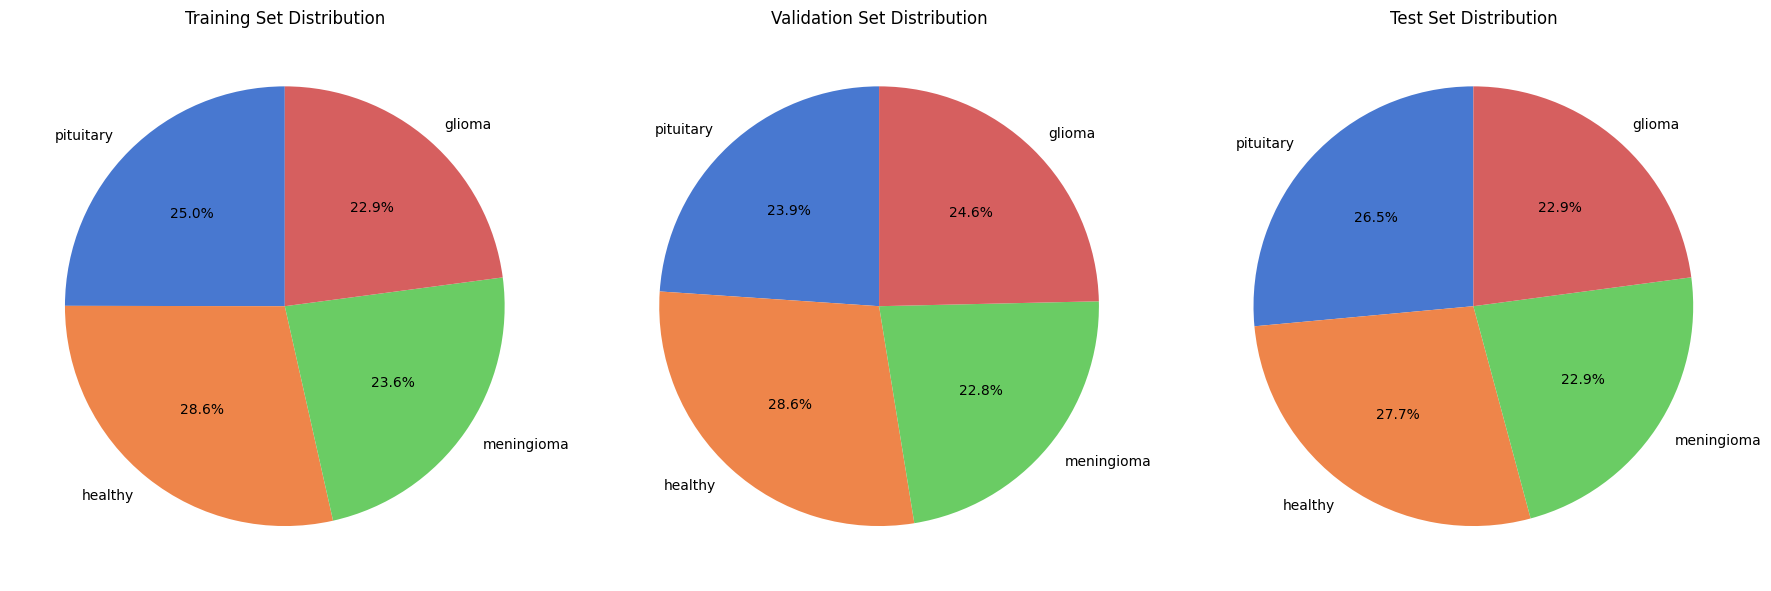

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def count_classes(dataset, label_map):
    """
    Counts the number of samples in each class for a PyTorch Dataset.

    Args:
        dataset (Dataset): The PyTorch Dataset to analyze.
        label_map (dict): A dictionary mapping label indices to class names.

    Returns:
        dict: A dictionary with class names as keys and counts as values.
    """
    class_counts = {class_name: 0 for class_name in label_map.values()}
    
    for _, label in dataset:
        class_name = label_map[label]
        class_counts[class_name] += 1

    return class_counts

# Extract class names and create label map
label_map = {idx: label for label, idx in dataset.label_map.items()}  # Reverse mapping

# Count class distributions
train_counts = count_classes(train_loader.dataset, label_map)
val_counts = count_classes(val_loader.dataset, label_map)
test_counts = count_classes(test_loader.dataset, label_map)

# Prepare data for visualization
data = {
    'Training Set': train_counts,
    'Validation Set': val_counts,
    'Test Set': test_counts
}

# Visualize class distributions as pie charts
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
muted_colors = sns.color_palette("muted", len(label_map))

for ax, (partition, counts) in zip(axes, data.items()):
    labels = counts.keys()
    sizes = counts.values()
    ax.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=muted_colors
    )
    ax.set_title(f'{partition} Distribution')

plt.tight_layout()
plt.show()


Number of training samples: 5618
Number of validation samples: 702
Number of testing samples: 703


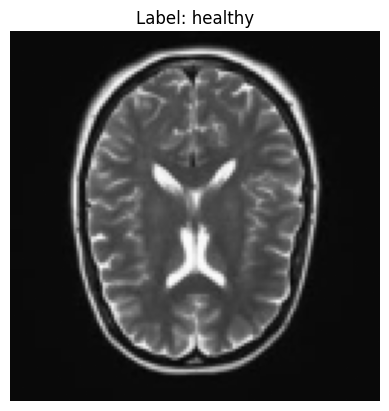

In [5]:
# Print dataset statistics
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

# Visualize a sample image with class name
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display a specific image and its corresponding class name
sample_idx = 5  # Change this index to view other images in the batch
img = images[sample_idx].permute(1, 2, 0).numpy() * 0.5 + 0.5  # Reverse normalization
class_name = label_map[labels[sample_idx].item()]  # Convert label number to class name

# Plot the image
plt.imshow(img)
plt.title(f"Label: {class_name}")
plt.axis("off")
plt.show()


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes):
        super(BrainTumorCNN, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        
        # Third convolutional layer
        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(512 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
        # ReLU activation and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Apply convolution and ReLU activation
        x = self.pool(self.relu(self.conv1(x)))  # Conv1 -> ReLU
        #print(x.shape)
        x = self.pool(self.relu(self.conv2(x)))  # Conv2 -> ReLU
        #print(x.shape)

        x = self.pool(self.relu(self.conv3(x)))  # Conv3 -> ReLU
        #print(x.shape)

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        #print(x.shape)

        
        # Fully connected layers with ReLU and dropout
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Output layer
        
        return x


In [7]:
model = BrainTumorCNN(num_classes=4)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the criterion (loss function) and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for classification tasks
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Optimizer with learning rate 0.001


In [8]:
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import accuracy_score
from tqdm import tqdm


# Initialize lists to store losses and accuracies
train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

num_epochs =20 
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    train_preds = []
    train_labels = []

    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)

    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_loader_tqdm.set_postfix({"Loss": f"{loss.item():.4f}"})
        
        # Collect predictions for accuracy calculation
        _, preds = torch.max(outputs, 1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Store training loss and accuracy
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = accuracy_score(train_labels, train_preds) * 100
    train_accuracies.append(train_accuracy)

    # Validation Phase
    model.eval()
    val_running_loss = 0.0
    val_preds = []
    val_labels = []

    val_loader_tqdm = tqdm(val_loader, desc="Validating", leave=False)
    with torch.no_grad():
        for images, labels in val_loader_tqdm:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_running_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = accuracy_score(val_labels, val_preds) * 100
    val_accuracies.append(val_accuracy)

    # Test Phase
    test_running_loss = 0.0
    test_preds = []
    test_labels = []

    test_loader_tqdm = tqdm(test_loader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for images, labels in test_loader_tqdm:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_running_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    test_accuracy = accuracy_score(test_labels, test_preds) * 100
    test_accuracies.append(test_accuracy)

    # Print epoch summary
    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, "
          f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Epoch 1/20


Epoch 1/20, Train Loss: 0.8189, Train Accuracy: 68.21%, Validation Loss: 0.4772, Validation Accuracy: 82.48%, Test Loss: 0.4754, Test Accuracy: 82.22%
Epoch 2/20


Epoch 2/20, Train Loss: 0.4797, Train Accuracy: 80.76%, Validation Loss: 0.3667, Validation Accuracy: 86.89%, Test Loss: 0.3752, Test Accuracy: 85.92%
Epoch 3/20


Epoch 3/20, Train Loss: 0.3595, Train Accuracy: 86.35%, Validation Loss: 0.2662, Validation Accuracy: 90.03%, Test Loss: 0.2810, Test Accuracy: 88.76%
Epoch 4/20


Epoch 4/20, Train Loss: 0.2738, Train Accuracy: 89.20%, Validation Loss: 0.2130, Validation Accuracy: 92.17%, Test Loss: 0.2567, Test Accuracy: 89.76%
Epoch 5/20


Epoch 5/20, Train Loss: 0.2278, Train Accuracy: 91.03%, Validation Loss: 0.1946, Validation Accuracy: 92.31%, Test Loss: 0.1934, Test Accuracy: 93.03%
Epoch 6/20


Epoch 6/20, Train Loss: 0.1744, Train Accuracy: 93.25%, Validation Loss: 0.2424, Validation Accuracy: 91.31%, Test Loss: 0.2306, Test Accuracy: 92.03%
Epoch 7/20


Epoch 7/20, Train Loss: 0.1419, Train Accuracy: 94.52%, Validation Loss: 0.1704, Validation Accuracy: 94.02%, Test Loss: 0.1685, Test Accuracy: 94.03%
Epoch 8/20


Epoch 8/20, Train Loss: 0.1151, Train Accuracy: 95.60%, Validation Loss: 0.1884, Validation Accuracy: 94.44%, Test Loss: 0.1713, Test Accuracy: 94.45%
Epoch 9/20


Epoch 9/20, Train Loss: 0.1202, Train Accuracy: 95.71%, Validation Loss: 0.1713, Validation Accuracy: 93.02%, Test Loss: 0.1786, Test Accuracy: 94.03%
Epoch 10/20


Epoch 10/20, Train Loss: 0.0818, Train Accuracy: 97.13%, Validation Loss: 0.2306, Validation Accuracy: 94.44%, Test Loss: 0.2007, Test Accuracy: 93.46%
Epoch 11/20


Epoch 11/20, Train Loss: 0.0939, Train Accuracy: 96.49%, Validation Loss: 0.1347, Validation Accuracy: 95.44%, Test Loss: 0.1254, Test Accuracy: 96.16%
Epoch 12/20


Epoch 12/20, Train Loss: 0.0601, Train Accuracy: 97.81%, Validation Loss: 0.1306, Validation Accuracy: 95.58%, Test Loss: 0.1223, Test Accuracy: 96.59%
Epoch 13/20


Epoch 13/20, Train Loss: 0.0516, Train Accuracy: 98.18%, Validation Loss: 0.1988, Validation Accuracy: 94.73%, Test Loss: 0.1706, Test Accuracy: 96.16%
Epoch 14/20


Epoch 14/20, Train Loss: 0.0426, Train Accuracy: 98.50%, Validation Loss: 0.1848, Validation Accuracy: 95.58%, Test Loss: 0.2064, Test Accuracy: 96.02%
Epoch 15/20


Epoch 15/20, Train Loss: 0.0572, Train Accuracy: 97.94%, Validation Loss: 0.1830, Validation Accuracy: 95.87%, Test Loss: 0.2045, Test Accuracy: 94.17%
Epoch 16/20


Epoch 16/20, Train Loss: 0.0494, Train Accuracy: 98.31%, Validation Loss: 0.1892, Validation Accuracy: 94.87%, Test Loss: 0.1836, Test Accuracy: 95.59%
Epoch 17/20


Epoch 17/20, Train Loss: 0.0402, Train Accuracy: 98.67%, Validation Loss: 0.1549, Validation Accuracy: 96.30%, Test Loss: 0.1371, Test Accuracy: 95.73%
Epoch 18/20


Epoch 18/20, Train Loss: 0.0457, Train Accuracy: 98.18%, Validation Loss: 0.1885, Validation Accuracy: 95.30%, Test Loss: 0.2315, Test Accuracy: 94.59%
Epoch 19/20


Epoch 19/20, Train Loss: 0.0647, Train Accuracy: 97.65%, Validation Loss: 0.1607, Validation Accuracy: 96.30%, Test Loss: 0.1477, Test Accuracy: 96.30%
Epoch 20/20


Epoch 20/20, Train Loss: 0.0447, Train Accuracy: 98.56%, Validation Loss: 0.2629, Validation Accuracy: 95.44%, Test Loss: 0.2039, Test Accuracy: 97.01%


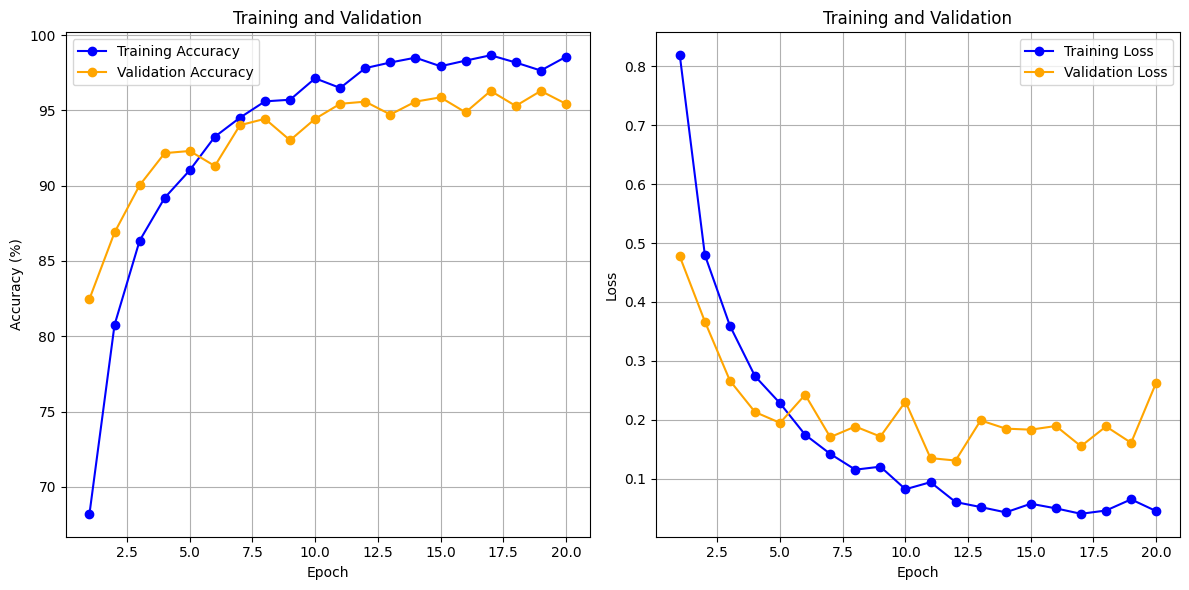

In [9]:
import matplotlib.pyplot as plt

# Plot Training, Validation, and Test Accuracies
plt.figure(figsize=(12, 6))
epochs = range(1, len(train_accuracies) + 1)

# Accuracies
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label="Training Accuracy", marker='o', linestyle='-', color='blue')
plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker='o', linestyle='-', color='orange')
#plt.plot(epochs, [test_accuracies[-1]] * len(epochs), label="Test Accuracy (Final)", linestyle='--', color='green')

plt.title("Training and Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

# Losses
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label="Training Loss", marker='o', linestyle='-', color='blue')
plt.plot(epochs, val_losses, label="Validation Loss", marker='o', linestyle='-', color='orange')
#plt.plot(epochs, [test_losses[-1]] * len(epochs), label="Test Loss (Final)", linestyle='--', color='green')

plt.title("Training and Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


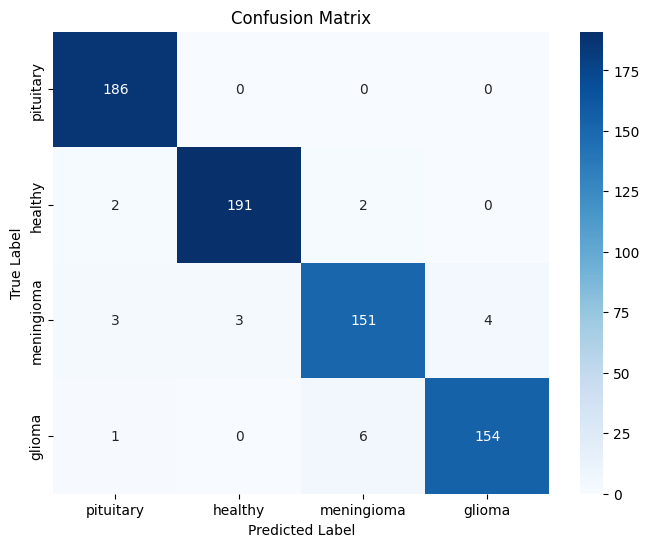

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming all_labels and all_preds are lists or arrays of true and predicted labels
conf_matrix = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=dataset.label_map.keys(), 
    yticklabels=dataset.label_map.keys()
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

True Label: healthy
Predicted Class: healthy


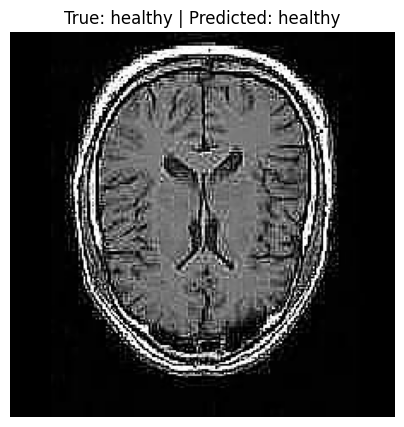

In [18]:
import cv2
import torch
from torchvision import transforms
import matplotlib.pyplot as plt


# Dataset and label map extraction
dataset = BrainTumorDataset(data_dir, transform=transform)

# Extract the label map for converting numeric labels back to class names
label_map = {idx: label for label, idx in dataset.label_map.items()}  # Reverse mapping

# Path to the image
image_path = "/kaggle/input/brain-tumor-mri-scans/healthy/0000.jpg"

# Load the image using cv2
original_image = cv2.imread(image_path)  # Load image
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Apply dataset transforms to the loaded image for matching
transformed_image = transform(original_image)  # Apply transformations (resize, normalization, etc.)

# Find the true label (compare transformed tensors)
true_label = None
for i in range(len(dataset)):
    img_tensor, label = dataset[i]
    if torch.equal(img_tensor, transformed_image):  # Compare tensors directly
        true_label = label_map[label]
        break

# Apply transforms to the original image for prediction
image_tensor = transformed_image.unsqueeze(0)  # Add a batch dimension

# Move the image to the same device as the model
image_tensor = image_tensor.to(device)

# Put the model in evaluation mode
model.eval()

# Make the prediction
with torch.no_grad():  # Disable gradient computation for inference
    outputs = model(image_tensor)
    predicted_class_index = torch.argmax(outputs, dim=1).item()

# Get the class name from the label map
predicted_class_name = label_map[predicted_class_index]

# Display the prediction and true label
print(f"True Label: {true_label if true_label else 'Unknown'}")
print(f"Predicted Class: {predicted_class_name}")

# Plot the image with its prediction and true label
plt.figure(figsize=(5, 5))
plt.imshow(original_image)
plt.title(f"True: {true_label if true_label else 'Unknown'} | Predicted: {predicted_class_name}")
plt.axis("off")
plt.show()
